# Data Analyses
## Synopsis Keywords

In this document, we investigate language aspects of the data to see if keywords (most used words) in synopsis is different between high performance vs low performance group in terms of popularity, box office sales, and rating.

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
sns.set_context("talk", font_scale=1.2)
sns.set_style("darkgrid")
%matplotlib inline

## Overview Data
First we will look at the words used in overview.  
Here we are interested in answering these two questions:  
1. What are the keywords for highly rated films?  
2. What are the keywords for popular films?  

In [196]:
# exporting data
df = pd.read_csv('data/profit_data.csv', index_col = 0)

## Missing Values
Since our focus is the text data, if it's missing the text data it's no point. We will drop the rows without overview data. But luckily there isn't any since we dealt with most of missing data in collection/cleaning.

# Popularity

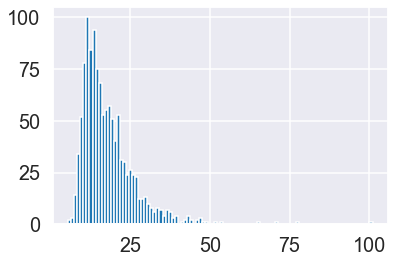

In [207]:
df.popularity.hist(bins = 100)

We will compare the most frequently used words from the movies with popularity higher than 90th quantile and movies with popularity lower than 10th quantile.

In [219]:
print(f"That means {len(df[df.popularity >= df.popularity.quantile(.95)])} movies from each group.")


That means 60 movies from each group.


In [254]:
## High popular group
highpop = df[df.popularity >= df.popularity.quantile(.95)].overview
## Low popular group
lowpop = df[df.popularity <= df.popularity.quantile(.05)].overview

## Focusing on meaning
Since we are looking for keywords, I want to exclude most of articles, prepositions, conjunctions, and pronouns. I'll make a preliminary list here. 

In [324]:
exclusion_list = ['the', 'a', 'to', 'of', 'in', 's', 'is', 'as', 'that', 
                'on', 'he', 'her', 'by', 'his', 'hers', 'for', 'who', 'whom', 'their', 
                'at', 'it', 'when', 'where', 'has', 'are', 'or', 'an', 'c', 'from',
                'one', 'they', 'she', 'this', 'out', 'up', 'into', 'was', 'which', 
                'will', 'have', 't', 'be', 'also', 'while', 'about', 'him', 'them', 
                'what', 'can', 'been', 'and', 'with', 'but', 'new', 'all', 'm', 'after', 
                 'against', 'behind', 'back', 'if', 'through', 'must', 'not', 'still', 'during', 
                 'before', 'how', 'within', 'most', 'down', 'between']

## Building Functions
I'll be running this on many groups so let's make a function

In [325]:
# Create a function that takes a string and create a list of keywords
def keywording(string):
    # remove special character, lowercase, then remove individual words
    return re.sub('[^A-Za-z0-9]+', ' ', string).lower().split() 

In [326]:
# Create a function that takes a list and remove exclusion words
def remove_exc(list_):
    return [x for x in list_ if x not in exclusion_list]

In [327]:
# Create a function that takes a list of strings 
# and turn it into a singlie list of keywords
def set_keywords(list_):
    ans = []
    for item in list_:
        clean = keywording(item)
        ans.extend(remove_exc(clean))
    return ans
        

In [328]:
# Create a function that takes a list of strings
# turn it into keywords then create a word counts dictionary

def count_words(list_):
    wordlist = set_keywords(list_)
    uniques = set(wordlist)
    counts = dict.fromkeys(uniques, 0)
    for word in wordlist:
        counts[word] += 1
    return {k: v for k, v in sorted(counts.items(), 
                                    reverse = True, key=lambda item: item[1])}
    

In [329]:
# Create a function that takes a list of strings and a title, 
# and plot a bar graph and wordcloud of top 20 most used words.


In [330]:
def plot_words(list_, title, fname):
    dic = count_words(list_)
    X = list(dic.keys())[0:20]
    Y = list(dic.values())[0:20]

    fig, ax = plt.subplots(1, 1, figsize=(8, 10))
    sns.barplot(x=X, y=Y, palette="husl", ax=ax)
    ax.set_ylabel("counts")
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()
    ax.figure.savefig(f"PNG/{fname}.png")
    
    wc = WordCloud(background_color="white", width=1200, height=800, max_words=50)
    wc.generate_from_frequencies(dic)

    plt.imshow(wc, interpolation="bilinear")
    wc.to_file(f"PNG/{fname}_wc.png")
    plt.axis("off")
    plt.show()


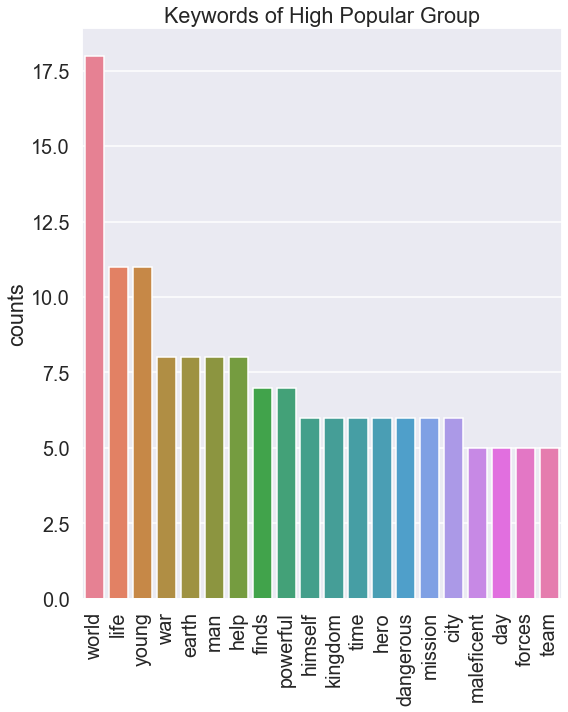

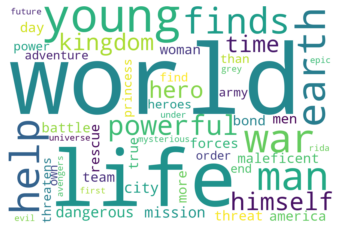

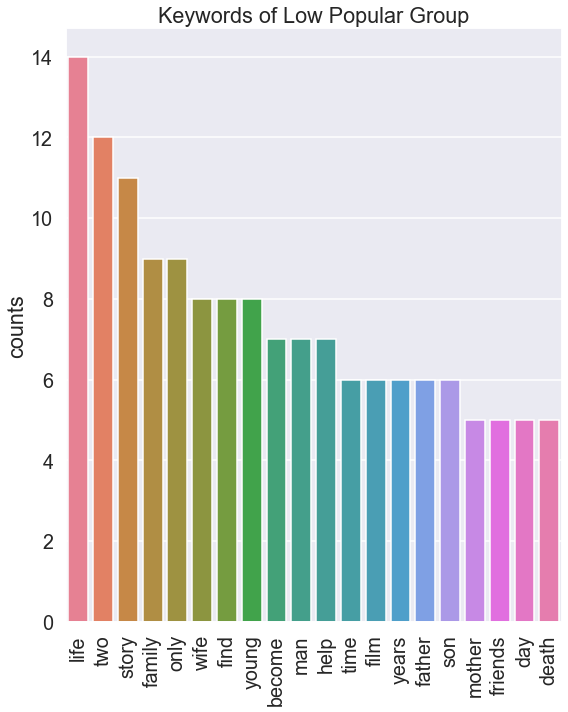

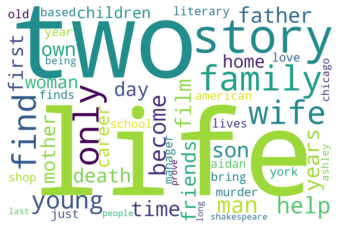

In [331]:
plot_words(highpop, 'Keywords of High Popular Group', 'Key_Highpop')
plot_words(lowpop, 'Keywords of Low Popular Group', 'Key_Lowpop')

## IMDB Rating
We will run the same analysis for high IMDB rating group and low group.


In [332]:
## High popular group
highrat = df[df.avg_rating_imdb >= df.avg_rating_imdb.quantile(.95)].overview
## Low popular group
lowrat = df[df.avg_rating_imdb <= df.avg_rating_imdb.quantile(.05)].overview

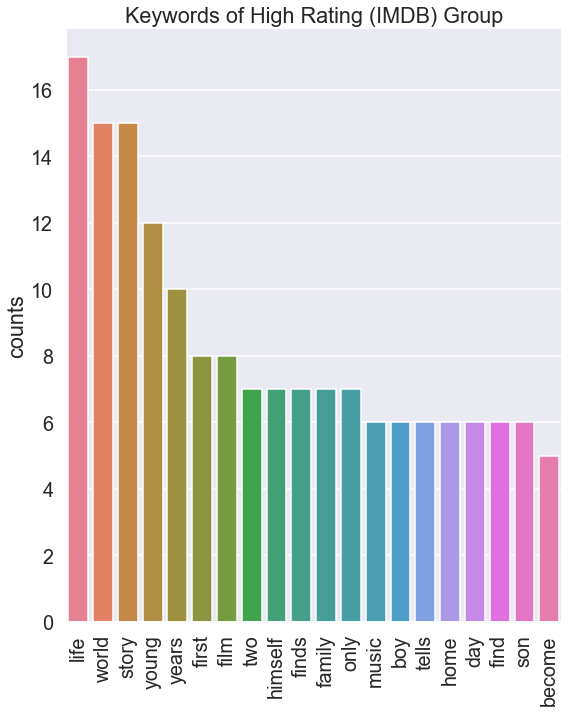

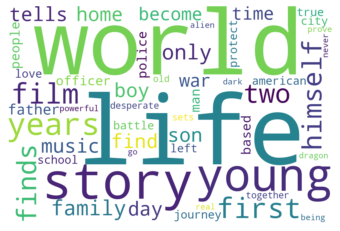

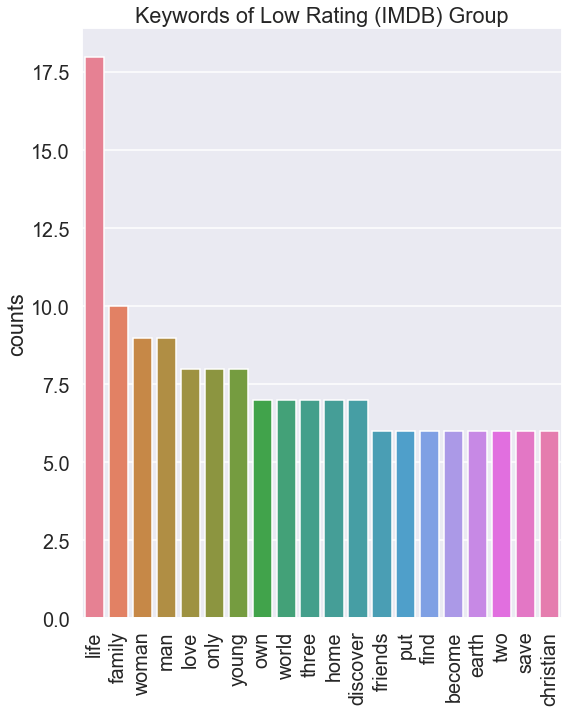

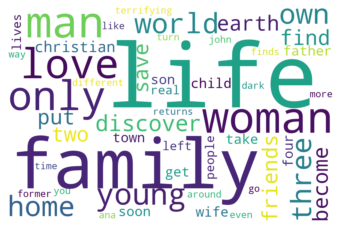

In [333]:
plot_words(highrat, 'Keywords of High Rating (IMDB) Group', 'Key_Highrate')
plot_words(lowrat, 'Keywords of Low Rating (IMDB) Group', 'Key_Lowrate')

## Rotten Tomatoes Box Office and Synopsis Keywords

In this section, we will see if top tier box office and low tier box office show any difference in keywords used in their descriptions of films.

In [334]:
df = pd.read_csv("zippedData/rt.movie_info.tsv", delimiter = '\t')

In [335]:
df.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


In [336]:
n = len(df[~df.box_office.isnull()])
print(f"{n} movies with box office information.")

340 movies with box office information.


We will only use the data with box_office information here  
since it's the primary dependent variable we shouldn't use a method that may bias the data. 

In [337]:
df.dropna(subset = ['box_office'], inplace = True)

In [338]:
# change number format to an integer
df.box_office = df.box_office.apply(lambda x: int(x.replace(',', '')))

I will divide the group into 3 tiers by box office number and see what are the most commonly used words to describe their synopsis in each groups.

In [339]:
n = round(len(df)/2)

df_t1 = df[0:n]
df_t2 = df[n:]
print(f"{len(df_t1)}, {len(df_t2)}")

170, 170


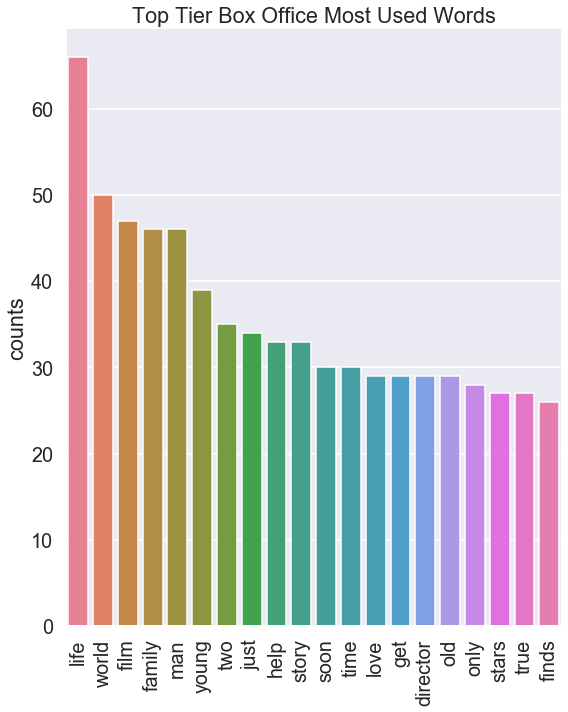

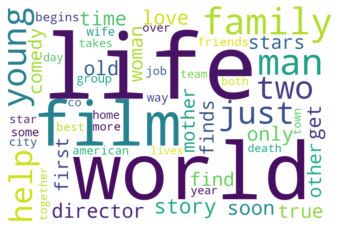

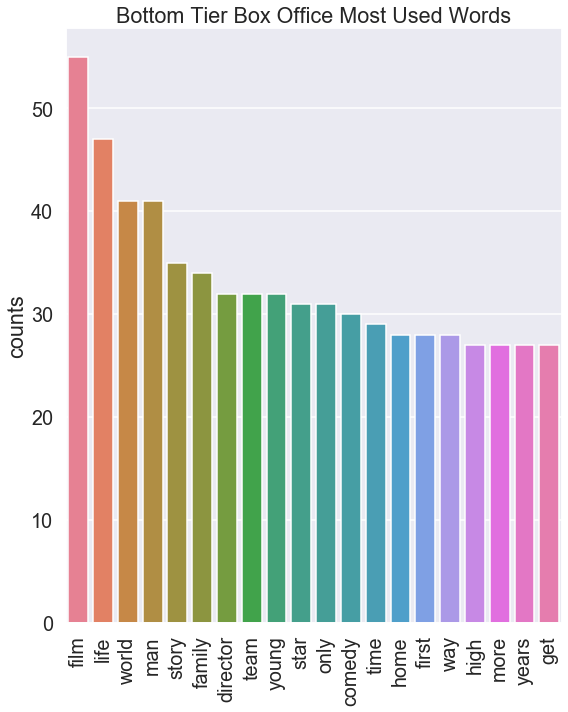

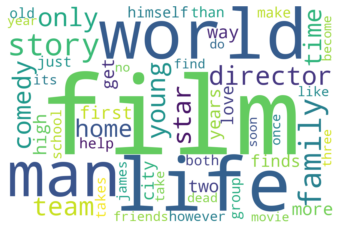

In [340]:
plot_words(df_t1.synopsis, 'Top Tier Box Office Most Used Words', 'Key_HighBoxOffice')
plot_words(df_t3.synopsis, "Bottom Tier Box Office Most Used Words", 'Key_LowBoxOffice')


In [341]:
# Average word counts may bias this results. So let's look at that
import statistics as stat
print(stat.mean(list(map(lambda x: len(x), df_t1.synopsis))))
print(stat.mean(list(map(lambda x: len(x), df_t2.synopsis))))


742.135294117647
753.3764705882353


One thing that might be interesting to look at is the use of words like 'not'